# Traditional ML Batch Forecasting on UCI Air Quality

This notebook performs **batch preprocessing and traditional ML forecasting** on the UCI Air Quality dataset:
- Loads `AirQualityUCI.csv` (semicolon-separated, decimal commas; `-200` → NaN)
- Builds a datetime index (`Date` + `Time`), sorts
- Feature engineering for supervised learning (lags, rolling stats, calendar)
- Creates **1–3 hour ahead** targets for **NO2(GT)** (modifiable)
- Time-ordered split: **Train 70% / Val 15% / Test 15%**
- Trains **HistGradientBoostingRegressor** (and optionally RandomForest) per horizon
- Evaluates with **MAE / RMSE / R²**
- Saves artifacts (models + report JSON) to `./artifacts/`

> You can change `CSV_PATH`, `TARGET`, `HORIZONS`, and other constants in the first code cell.


In [110]:

# === Configuration ===
CSV_PATH = "Data/AirQualityUCI.csv"  # Path to the uploaded CSV
TARGET = "AH"                        # Suggested: "NO2(GT)" | other options: "CO(GT)", "NOx(GT)"
HORIZONS = [1, 2, 3]                      # Forecast 1–3 hours ahead
TRAIN_FRAC = 0.70
VAL_FRAC = 0.15
ARTIFACT_DIR = "./artifacts"
USE_RANDOM_FOREST = False                 # If True, also train RandomForest in addition to HGB
SEED = 42


In [111]:
import os
import json
from datetime import datetime

import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import HistGradientBoostingRegressor, RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.inspection import permutation_importance
import joblib
import matplotlib.pyplot as plt

os.makedirs(ARTIFACT_DIR, exist_ok=True)
print("Artifacts will be saved to:", os.path.abspath(ARTIFACT_DIR))


Artifacts will be saved to: c:\Users\25fad\Documents\Msc\3rd semester\Open-Source Tech\ost-sm-air-quality\artifacts


## 1) Load & Inspect

In [112]:
def load_uci(csv_path: str) -> pd.DataFrame:
    df = pd.read_csv(
        csv_path,
        sep=';',
        decimal=',',
        na_values=[-200, "-200"],
        low_memory=False,
        encoding='latin1'
    )
    # Drop potential empty columns
    df = df.drop(columns=[c for c in df.columns if c.startswith("Unnamed")], errors='ignore')
    # Build datetime
    def fix_time(t): return str(t).replace('.', ':')
    dt = pd.to_datetime(df["Date"] + " " + df["Time"].map(fix_time), dayfirst=True, errors="coerce")
    df = df.drop(columns=["Date", "Time"])
    df.insert(0, "datetime", dt)
    df = df.set_index("datetime").sort_index()
    # If duplicates per hour, average
    df = df.groupby(level=0).mean(numeric_only=True)
    return df

df = load_uci(CSV_PATH)
print(df.shape, df.index.min(), "→", df.index.max())
df.head()


(9357, 13) 2004-03-10 18:00:00 → 2005-04-04 14:00:00


,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
datetime,,,,,,,,,,,,,
2004-03-10 18:00:00,2.6,1360.0,150.0,11.9,1046.0,166.0,1056.0,113.0,1692.0,1268.0,13.6,48.9,0.7578
2004-03-10 19:00:00,2.0,1292.0,112.0,9.4,955.0,103.0,1174.0,92.0,1559.0,972.0,13.3,47.7,0.7255
2004-03-10 20:00:00,2.2,1402.0,88.0,9.0,939.0,131.0,1140.0,114.0,1555.0,1074.0,11.9,54.0,0.7502
2004-03-10 21:00:00,2.2,1376.0,80.0,9.2,948.0,172.0,1092.0,122.0,1584.0,1203.0,11.0,60.0,0.7867
2004-03-10 22:00:00,1.6,1272.0,51.0,6.5,836.0,131.0,1205.0,116.0,1490.0,1110.0,11.2,59.6,0.7888


In [113]:
# Missingness summary
missing_pct = df.isna().mean().sort_values(ascending=False).to_frame("missing_pct")
missing_pct.head(10)

,missing_pct
NMHC(GT),0.902319
CO(GT),0.179865
NO2(GT),0.175484
NOx(GT),0.175163
PT08.S1(CO),0.039115
PT08.S2(NMHC),0.039115
C6H6(GT),0.039115
PT08.S3(NOx),0.039115
PT08.S4(NO2),0.039115
PT08.S5(O3),0.039115


## 2) Supervised Feature Engineering

In [114]:
def add_time_features(x: pd.DataFrame) -> pd.DataFrame:
    out = x.copy()
    idx = out.index
    out["hour"] = idx.hour
    out["dow"] = idx.dayofweek
    out["month"] = idx.month
    out["is_weekend"] = (out["dow"] >= 5).astype(int)
    return out

def make_supervised(
    df: pd.DataFrame,
    target: str,
    horizons=(1, 2, 3),
    lag_hours=(1, 2, 3, 6, 12, 24),
    roll_windows=(3, 6, 12)
):
    data = add_time_features(df)
    if target not in data.columns:
        raise ValueError(f"Target '{target}' not found in columns: {list(data.columns)}")

    # numeric columns only
    num_cols = [c for c in data.columns if pd.api.types.is_numeric_dtype(data[c])]
    X = pd.DataFrame(index=data.index)

    # Lags + rolling stats (shift to avoid leakage)
    for c in num_cols:
        for L in lag_hours:
            X[f"{c}_lag{L}"] = data[c].shift(L)
        for W in roll_windows:
            X[f"{c}_rollmean{W}"] = data[c].shift(1).rolling(W).mean()
            X[f"{c}_rollstd{W}"] = data[c].shift(1).rolling(W).std()

    # Calendar features
    X[["hour", "dow", "month", "is_weekend"]] = add_time_features(
        pd.DataFrame(index=data.index)
    ).reindex(X.index)

    # Targets
    ys = {h: data[target].shift(-h).rename(f"{target}_H{h}") for h in horizons}

    combined = pd.concat([X] + [ys[h] for h in horizons], axis=1).dropna()
    X_final = combined[X.columns]
    ys_final = {h: combined[f"{target}_H{h}"] for h in horizons}
    return X_final, ys_final

X, ys = make_supervised(df, TARGET, horizons=tuple(HORIZONS))
X.shape, {k: len(v) for k, v in ys.items()}

C:\Users\25fad\AppData\Local\Temp\ipykernel_22748\3118543376.py:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X[f"{c}_lag{L}"] = data[c].shift(L)
C:\Users\25fad\AppData\Local\Temp\ipykernel_22748\3118543376.py:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X[f"{c}_lag{L}"] = data[c].shift(L)
C:\Users\25fad\AppData\Local\Temp\ipykernel_22748\3118543376.py:30: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining al

((300, 208), {1: 300, 2: 300, 3: 300})

## 3) Time-Ordered Train / Val / Test Split

In [115]:
def time_split(X: pd.DataFrame, y: pd.Series, train_frac=0.7, val_frac=0.15):
    n = len(X)
    n_train = int(n * train_frac)
    n_val = int(n * val_frac)
    idx_train = slice(0, n_train)
    idx_val = slice(n_train, n_train + n_val)
    idx_test = slice(n_train + n_val, n)
    return (X.iloc[idx_train], y.iloc[idx_train],
            X.iloc[idx_val], y.iloc[idx_val],
            X.iloc[idx_test], y.iloc[idx_test])

# Split using first horizon's index and reuse for others
h0 = HORIZONS[0]
X_tr, y_tr, X_val, y_val, X_te, y_te = time_split(X, ys[h0], TRAIN_FRAC, VAL_FRAC)
idx_tr, idx_val, idx_te = X_tr.index, X_val.index, X_te.index
len(X_tr), len(X_val), len(X_te)

(210, 45, 45)

## 4) Train Models per Horizon

In [116]:
def build_hgb_pipeline():
    pipe = Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("model", HistGradientBoostingRegressor(random_state=SEED)),
    ])
    return pipe

def build_rf_pipeline():
    pipe = Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("model", RandomForestRegressor(n_estimators=500, n_jobs=-1, random_state=SEED)),
    ])
    return pipe

def evaluate(y_true, y_pred):
    return {
        "MAE": float(mean_absolute_error(y_true, y_pred)),
        "RMSE": float(mean_squared_error(y_true, y_pred) ** 0.5),
        "R2": float(r2_score(y_true, y_pred))
    }

report = {
    "target": TARGET,
    "horizons": HORIZONS,
    "rows_total": int(len(X)),
    "rows_train": int(len(X_tr)),
    "rows_val": int(len(X_val)),
    "rows_test": int(len(X_te)),
    "models": {}
}

# Fit per horizon
for h in HORIZONS:
    print(f"--- Horizon H+{h} ---")
    y_h = ys[h]
    y_tr_h = y_h.loc[idx_tr]
    y_val_h = y_h.loc[idx_val]
    y_te_h = y_h.loc[idx_te]

    # Baseline: HGB
    hgb = build_hgb_pipeline()
    hgb.fit(pd.concat([X_tr, X_val]), pd.concat([y_tr_h, y_val_h]))  # train+val fit
    val_pred = hgb.predict(X_val)
    te_pred = hgb.predict(X_te)

    metrics_hgb = {
        "val": evaluate(y_val_h, val_pred),
        "test": evaluate(y_te_h, te_pred),
    }

    model_paths = {}
    path_hgb = os.path.join(ARTIFACT_DIR, f"model_{TARGET.replace('/', '-')}_H{h}_hgb.joblib")
    joblib.dump(hgb, path_hgb)
    model_paths["hgb"] = path_hgb

    # Optional: RandomForest
    metrics_rf = None
    if USE_RANDOM_FOREST:
        rf = build_rf_pipeline()
        rf.fit(pd.concat([X_tr, X_val]), pd.concat([y_tr_h, y_val_h]))
        val_pred_rf = rf.predict(X_val)
        te_pred_rf = rf.predict(X_te)
        metrics_rf = {
            "val": evaluate(y_val_h, val_pred_rf),
            "test": evaluate(y_te_h, te_pred_rf),
        }
        path_rf = os.path.join(ARTIFACT_DIR, f"model_{TARGET.replace('/', '-')}_H{h}_rf.joblib")
        joblib.dump(rf, path_rf)
        model_paths["rf"] = path_rf

    # Permutation importances (top 20) on validation sample
    top_features = None
    try:
        sample_n = min(1000, len(X_val))
        perm = permutation_importance(hgb, X_val.iloc[-sample_n:], y_val_h.iloc[-sample_n:], n_repeats=5, random_state=SEED, n_jobs=-1)
        importances = pd.Series(perm.importances_mean, index=X_val.columns).sort_values(ascending=False).head(20)
        top_features = importances.to_dict()
    except Exception as e:
        top_features = {"error": str(e)}

    report["models"][f"H+{h}"] = {
        "paths": model_paths,
        "metrics_hgb": metrics_hgb,
        "metrics_rf": metrics_rf,
        "top_features_val": top_features
    }

# Save report
report_path = os.path.join(ARTIFACT_DIR, f"report_{TARGET.replace('/', '-')}.json")
with open(report_path, "w") as f:
    json.dump(report, f, indent=2)

print(json.dumps(report, indent=2))
report_path

--- Horizon H+1 ---
--- Horizon H+2 ---
--- Horizon H+3 ---
{
  "target": "AH",
  "horizons": [
    1,
    2,
    3
  ],
  "rows_total": 300,
  "rows_train": 210,
  "rows_val": 45,
  "rows_test": 45,
  "models": {
    "H+1": {
      "paths": {
        "hgb": "./artifacts\\model_AH_H1_hgb.joblib"
      },
      "metrics_hgb": {
        "val": {
          "MAE": 0.005833706276254692,
          "RMSE": 0.009869737125592266,
          "R2": 0.9980214292691993
        },
        "test": {
          "MAE": 0.080518104567138,
          "RMSE": 0.10946768386808305,
          "R2": 0.746412246753744
        }
      },
      "metrics_rf": null,
      "top_features_val": {
        "AH_lag1": 0.34958058582450907,
        "AH_rollmean3": 0.035338137157964036,
        "AH_lag3": 0.02496630490360885,
        "AH_rollmean12": 0.013947297087069321,
        "PT08.S3(NOx)_rollmean12": 0.013646888181629601,
        "AH_lag2": 0.011390781058848342,
        "PT08.S5(O3)_rollmean12": 0.005449093775474245,
  

'./artifacts\\report_AH.json'

## 5) Visualize Forecast vs. Actual (Test set)

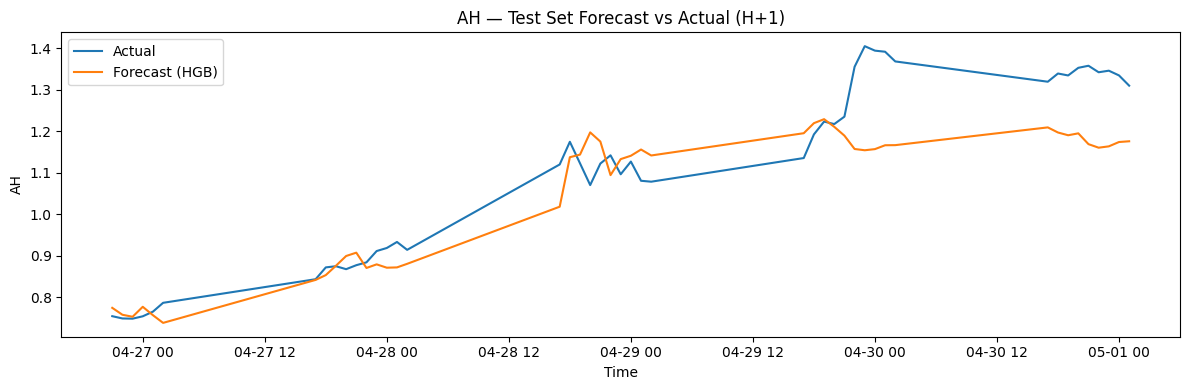

In [117]:
# Plot for the first horizon
h_plot = HORIZONS[0]
y_h = ys[h_plot]
y_tr_h = y_h.loc[idx_tr]
y_val_h = y_h.loc[idx_val]
y_te_h = y_h.loc[idx_te]

# Reload trained HGB for plotting (ensures consistent object)
import joblib
model_path = os.path.join(ARTIFACT_DIR, f"model_{TARGET.replace('/', '-')}_H{h_plot}_hgb.joblib")
hgb = joblib.load(model_path)

te_pred = hgb.predict(X_te)

plt.figure(figsize=(12, 4))
plt.plot(y_te_h.index, y_te_h.values, label="Actual")
plt.plot(y_te_h.index, te_pred, label="Forecast (HGB)")
plt.title(f"{TARGET} — Test Set Forecast vs Actual (H+{h_plot})")
plt.xlabel("Time")
plt.ylabel(TARGET)
plt.legend()
plt.tight_layout()
plt.show()